# SPC Photon Cube Reader (Based on spsim)

In [45]:
DATA_PATH = "../dataset/binary/f1000/"
SPLIT = "train"

### Imports

In [13]:
import numpy as  np
from torch.utils.data import Dataset
from pathlib import Path
import torch
import json
import matplotlib.pyplot as plt
from PIL import Image

### (Un)Packing

In [2]:
def packbits(image: np.ndarray, dim: int = 1) -> np.ndarray:
    """Pack a single binary frame of shape (H, W, C) into (ceil(H/8), W, C) or (H, ceil(W/8), C)

    Args:
        image: Input binary image as np array.
        dim: Int representing which dimension to pack, 0(height) and 1(width). Defaults to 1.

    :returns:
        Binary image packed in specified dimension as np array.
    """
    if dim not in (0, 1):
        raise NotImplementedError(f"Bit packing can only be done along height (dim=0) or height (dim=1), got {dim}.")
    if image.dtype != np.uint8:
        raise TypeError(f"Can only bitpack uint8 types, got {image.dtype}.")
    return np.packbits(image, axis=dim)


def unpackbits(image: np.ndarray, dim: int = 1) -> np.ndarray:
    """Unpack a single binary frame of shape (H, W, C) into (H*8, W, C) or (H, W*8, C)
        Note: If the original frame's size long `dim` is not a multiple of 8, then unpack(pack)
        might lead to a different image shape, which has been rounded off to a multiple of 8.

    Args:
        image: Input binary image as np array.
        dim: Int representing which dimension to unpack in, 0(height) and 1(width). Defaults to 1.

    :returns:
        Binary images unpacked in specified dimenision as np array.
    """
    if dim not in (0, 1):
        raise NotImplementedError(f"Bit unpacking can only be done along height (dim=0) or height (dim=1), got {dim}.")
    if image.dtype != np.uint8:
        raise TypeError(f"Can only unpack uint8 types, got {image.dtype}.")
    return np.unpackbits(image, axis=dim)

### Scratch It Bernie!

In [3]:
data = np.load(str(DATA_PATH+SPLIT+"/frames.npy"), mmap_mode="r")
bitpack = True
bitpack_dim = 2
h, w, c = 800, 800, 3
with open(DATA_PATH+SPLIT+"/transforms.json", "r") as f:
    transforms = json.load(f)
full_shape = (len(transforms['frames']), h, w, c)
# _idxs = [np.arange(size).astype(int) for size in full_shape]

NameError: name 'DATA_PATH' is not defined

In [18]:
# # save all bit-unpacked images on disk  --- Are you Fking crazy dude???
# !pip3 install -Uqq tqdm
# from tqdm.auto import tqdm
# import os

# os.makedirs(DATA_PATH+SPLIT+"/images", exist_ok=True)
# for i in tqdm(range(len(data))):
#     img = data[i]
#     img = np.unpackbits(img, axis=bitpack_dim-1)
#     img = (img*255.).astype(np.uint8)
#     img_number_zfilled = str(i).zfill(6)
#     plt.imsave(DATA_PATH+SPLIT+"/images/frame_"+img_number_zfilled+".png", img)

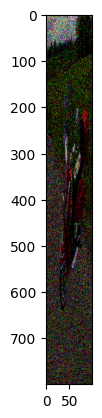

In [19]:
exp = data[0]
# id, h, w, c
plt.imshow(exp)
plt.show()

(800, 800, 3)


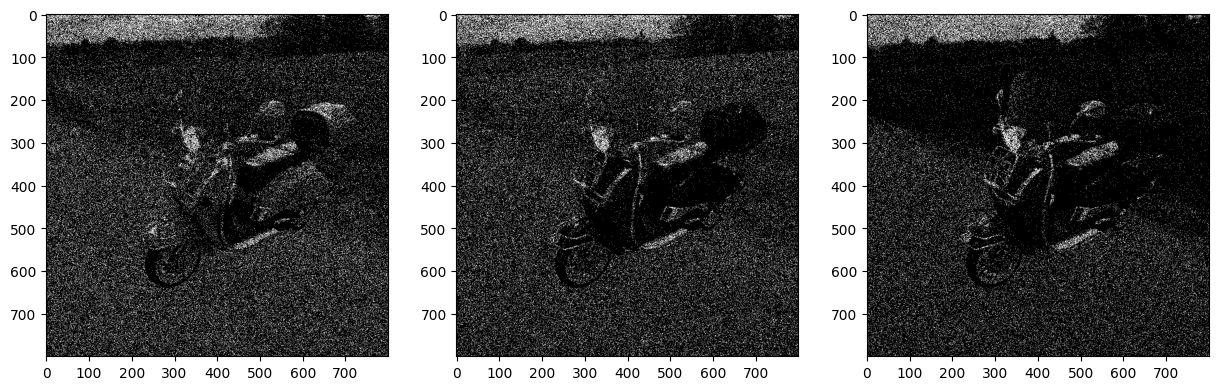

In [20]:
unpacked_exp = unpackbits(exp, dim=bitpack_dim-1)
print(unpacked_exp.shape)

# Show all three channels side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    ax.imshow(unpacked_exp[..., i], cmap="gray")
plt.show()

In [21]:
def srgb_to_linearrgb(img):
    module, img = (torch, img.clone()) if torch.is_tensor(img) else (np, np.copy(img))
    mask = img < 0.04045
    img[mask] = module.clip(img[mask], 0.0, module.inf) / 12.92
    img[~mask] = ((img[~mask] + 0.055) / 1.055) ** 2.4
    return img


def apply_alpha(img, alpha_color=(1.0, 1.0, 1.0), ret_alpha=True):
    if not np.issubdtype(img.dtype, np.floating):
        raise RuntimeError("Expected image to be of dtype float.")

    # At least 3d with added axis appended to end
    original_shape = img.shape
    img = np.expand_dims(img, -1 if img.ndim == 2 else ())

    # Get image and alpha
    img, alpha = np.split(img, [-1], axis=-1) if img.shape[-1] == 4 else (img, 1.0)

    if isinstance(alpha, np.ndarray) and (alpha.max() > 1.0 or alpha.min() < 0.0):
        raise RuntimeError("Expected alpha channel to be normalized to the range [0, 1].")

    # If image does not have 4 channels, pass through
    if original_shape[-1] != 4 or alpha_color is None:
        return (img, alpha) if ret_alpha else img

    img = img * alpha + np.array(alpha_color) * (1 - alpha)

    return (img, alpha) if ret_alpha else img


def linearrgb_to_srgb(img):
    module, img = (torch, img.clone()) if torch.is_tensor(img) else (np, np.copy(img))
    mask = img < 0.0031308
    img[img < 0.0] = 0.0
    img[mask] = img[mask] * 12.92
    img[~mask] = module.clip(1.055 * img[~mask] ** (1.0 / 2.4) - 0.055, 0.0, 1.0)
    return img



def emulate_rgb_from_merged(patch, burst_size=200, readout_std=20, fwc=500, factor=1.0, generator=None):
    # Input patch is average of `burst_size` linear-intensity frames, get sum by multiplying.
    patch = patch * burst_size

    # Above sum is in range [0, burst_size*factor]
    # Perform poisson sampling and add zero-mean gaussian read noise
    patch = torch.poisson(patch, generator=generator)
    patch += torch.normal(torch.zeros_like(patch), readout_std, generator=generator)

    # Normalize by full well capacity, clip highlights, and quantize to 12-bits
    patch = torch.clip(patch / fwc, 0, 1.0)
    patch = torch.round(patch * 2**12) / 2**12

    # Multiply by gain to keep constant(-ish) brightness
    patch *= fwc / (burst_size * factor)

    # Convert to sRGB color space for viewing and quantize to 8-bits
    patch = linearrgb_to_srgb(patch)
    patch = torch.round(patch * 2**8) / 2**8
    return patch

# def tensor_to_img(*tensors):
#     imgs = [
#         tgm.utils.tensor_to_image(i.detach().cpu().squeeze()) if torch.is_tensor(i) else i.squeeze() for i in tensors
#     ]
#     # RY. make sure valid range, and at least 3d
#     imgs = [np.clip(i, 0, 255).astype(np.uint8) if np.nanmax(i) > 1.0 else i.astype(float) for i in imgs]
#     imgs = [np.nan_to_num(np.atleast_3d(i)) for i in imgs]
#     return imgs if len(imgs) != 1 else imgs[0]


In [22]:
imgs = []
imgs = sum((i.astype(float) / 255.0).astype(float) for i in imgs)
idxs = []
idxs = np.array(idxs)

imgs = imgs.squeeze() / len(idxs)
# Assume image has been tonemapped and undo mapping
imgs = srgb_to_linearrgb(imgs)
imgs, alpha = apply_alpha(imgs, ret_alpha=True)

rgb_img = emulate_rgb_from_merged(
    img_to_tensor(imgs[..., 0] * 1.0),
    burst_size=10, # play around with this
    readout_std=20.,
    fwc=500.,
    factor=1.0,
)
rgb_img = tensor_to_img(rgb_img * 255)
if rgb_img.shape[-1] == 1:
    rgb_img = np.repeat(rgb_img, 3, axis=-1)

AttributeError: 'int' object has no attribute 'squeeze'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


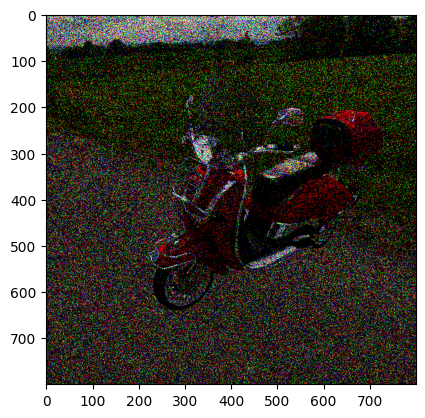

In [12]:
from PIL import Image
# pil = Image.fromarray(unpacked_exp).convert("RGB")
# plt.imshow(pil)
# plt.show()

plt.imshow(unpacked_exp*255.)
plt.show()

In [29]:
bin_img = Image.open("./HDRSplat/bin_img.png")
# SHow the image
bin_img = np.array(bin_img).transpose(2, 0, 1)
print(bin_img.shape)
print(np.amax(bin_img), np.amin(bin_img))


(3, 800, 800)
1 0


In [ ]:
idx = np.atleast_1d(idx).tolist()
idx += [slice(None)] * (data.ndim - len(idx))
img_idx, *_ = idx

# If the index of a given dimension is an integer, that dimension gets collapsed.
# We keep track of which dims need to be squeezed and only squeeze them at the end.
collapsed_dims = [isinstance(dim_idx, (int, np.integer)) for dim_idx in idx]

# Replace all idxs that would collapse a dimension with a slice of size 1.
# Note: The "i+1 or None" is important here, if i=-1 and we let the slice end be zero,
#   then the resulting slice (-1:0) will always be empty!
idx = [slice(i, i + 1 or None) if isinstance(i, (int, np.integer)) else i for i in idx]

# The index along the packed dimension might be a slice so we get all indices the slice
# would correspond to by using a proxy array.
# Note: If we don't copy here, numpy might return a view which will be modified below
#   leading to bizarre and inconsistent _silent_ errors.

idx[bitpack_dim] = np.copy(_idxs[bitpack_dim][idx[bitpack_dim]]).flatten()
# Compute the packed index and a secondary bit idx.
# If we were unpacking into a new dimension then the bit index would simply be %8 of
# the packed index. However, numpy's unpack bits does not do this, instead it lengths
# the axis along which we unpack by a factor of 8. We need to shift the bit indices
# by this lengthening factor.
# Ex:
#   Real indices along packed axis:         [31, 8, 121]
#   Packed indices:                         [ 3,  1, 15]
#   Bit indices (no shift):                 [ 0,  0,  1]
#   Bit indices (shifted correct amount):   [ 0,  8, 17]
# Note: The `bit_idx` is made into at least a 1d idx as to preserve dimensionality,
#   otherwise it would mess up the `collapsed_dims` above.
bit_idx = idx[self.bitpack_dim] % 8
idx[self.bitpack_dim] //= 8
bit_idx += np.arange(bit_idx.size) * 8

# Perform the indexing, unpacking, bit indexing and dimensionality reduction.
data = np.unpackbits(self.data[tuple(idx)], axis=self.bitpack_dim)
data = np.take(data, bit_idx, axis=self.bitpack_dim)

squeeze_dims = tuple(
    i for i, (size, collapsed) in enumerate(zip(collapsed_dims, data.shape)) if collapsed and size == 1
)

data = data.squeeze(axis=squeeze_dims)

## Exp with rgb npys and transforms

In [48]:
from PIL import Image

In [108]:
path_data = "/nobackup3/aryan/dataset/binary/f1000/train/frames.npy"
data_npy = np.load(path_data, mmap_mode="r")

In [111]:
cam_name = "000000_001600"
left, right = cam_name.split("_")
left, right = int(left), int(right)
print(left, ",", right)
# Unbitpack and average all frames from left to right
this_window = []
for i in range(left, right):
    this_window.append(np.unpackbits(data_npy[i], axis=1))
fps200_frame = np.mean(this_window, axis=0)
print(fps200_frame.shape, np.amax(fps200_frame), np.amin(fps200_frame))

0 , 1600
(800, 800, 3) 0.86 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6].


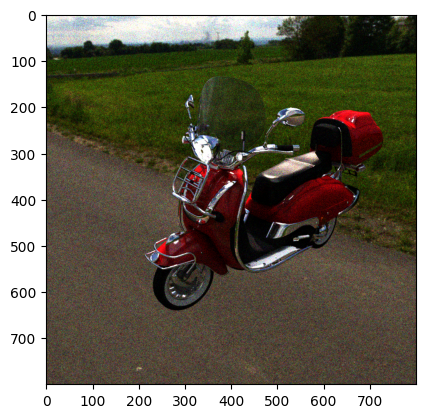

In [116]:
# plt.imshow((fps200_frame - np.amin(fps200_frame)) / (np.amax(fps200_frame) - np.amin(fps200_frame)))
plt.imshow(1.6*((1/np.amax(fps200_frame)) * fps200_frame))
plt.show()

In [55]:
print(fps200_frame.shape, np.amax(fps200_frame), np.amin(fps200_frame))

(800, 100, 3) 229.97 0.0


In [6]:
import os
from tqdm import tqdm
import math
import numpy as np
import json

In [7]:
def focal2fov(focal, pixels):
    return 2*math.atan(pixels/(2*focal))

def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))

In [8]:
splits = [0, 8000, 15000, 21000, 26000]
data_npy = np.load("../dataset/binary/f1000/train/frames.npy", mmap_mode="r")    
with open("../dataset/binary/f1000/train/transforms.json") as json_file:
    contents = json.load(json_file)
    fovx = contents["angle_x"]
    frames = contents["frames"]
        # len_frames = len(frames) =~ 800,000
    chunk_sizes = [40000 // 25, 40000 // 50, 40000 // 100, 40000 // 200, 1] 
    os.makedirs(f"../dataset/avg_00{str(40000//chunk_sizes[0])}fps", exist_ok=True)
    os.makedirs(f"../dataset/avg_00{str(40000//chunk_sizes[1])}fps", exist_ok=True)
    os.makedirs(f"../dataset/avg_00{str(40000//chunk_sizes[2])}fps", exist_ok=True)
    os.makedirs(f"../dataset/avg_00{str(40000//chunk_sizes[3])}fps", exist_ok=True)
        # chunk size = total_frames // capture_time * fps OR total_frames // num_frames in that fps bucket 
        # Ex - Our capture time was 20s, fps was 25, so chunk size = 40000 // 25 = 1600
    for split_idx in range(len(splits)):
        these_cams = 0
        if chunk_sizes[split_idx] == 1:
            continue
        for idx in tqdm(range(0, len(frames), chunk_sizes[split_idx])):
            # check if idx + chunk_sizes[split_idx] is within bounds and even
            if idx + chunk_sizes[split_idx] >= len(frames):
                break
            if (idx + chunk_sizes[split_idx]) % 2 != 0:
                continue
            middle_cam_idx = (idx + chunk_sizes[split_idx]) // 2
            cam_name = str(middle_cam_idx).zfill(6)
            save_path = f"../dataset/avg_00{40000//chunk_sizes[split_idx]}fps"
            left = idx
            right = idx + chunk_sizes[split_idx]
            this_window = []
            for i in range(left, right):
                this_window.append(np.unpackbits(data_npy[i], axis=1))
            fps_frame = np.mean(this_window, axis=0)
            fps_frame = (1.6 / np.amax(fps_frame)) * fps_frame
            # clip the frame to 0 - 1
            fps_frame = np.clip(fps_frame, 0, 1)

            # Save the frame
            plt.imsave(os.path.join(save_path, f"frame_{cam_name}.png"), fps_frame)
            these_cams += 1
            # Save the cam info
            c2w = np.array(frames[middle_cam_idx]["transform_matrix"])
            c2w[:3, 1:3] *= -1
            w2c = np.linalg.inv(c2w)
            R = np.transpose(w2c[:3,:3])  
            T = w2c[:3, 3]
            
            height = 800
            width = 800
            fovy = focal2fov(fov2focal(fovx, width), height)
            FovY = fovy 
            FovX = fovx
            uid = idx
            image_path = os.path.join(save_path, f"frame_{cam_name}.png")
            iterate_after = splits[split_idx]
            
            cam_info = {
                "R": R,
                "T": T,
                "FovY": FovY,
                "FovX": FovX,
                "height": height,
                "width": width,
                "uid": uid,
                "image_path": image_path,
                "iterate_after": iterate_after
            }
            # save the cam info in npy
            np.save(os.path.join(save_path, f"cam_{cam_name}.npy"), cam_info)
        print(f"Saved {these_cams} cams for chunk size {chunk_sizes[split_idx]}")

 91%|█████████ | 453/500 [55:06<13:08, 16.77s/it]  

In [21]:
40000 // 25, 40000 // 50, 40000 // 100, 40000 // 200, 1

(1600, 800, 400, 200, 1)

### Checking the pre-processed stuff

In [10]:
lookup="/nobackup3/aryan/dataset/avg_0025fps"
import os
import numpy as np
import matplotlib.pyplot as plt
import json

In [ ]:
CameraInfo(uid=idx, 
           R=R,
           T=T, 
           FovY=FovY, 
           FovX=FovX, 
            image_path=image_path, 
            image_name=image_name, 
            width=width, 
            height=height, 
            iterate_after=splits[split_idx])

In [11]:
for f in os.listdir(lookup):
    if f.endswith(".npy"):
        cam_info = np.load(os.path.join(lookup, f), allow_pickle=True).item()
        print(cam_info.keys())
        break

dict_keys(['R', 'T', 'FovY', 'FovX', 'height', 'width', 'uid', 'image_path', 'iterate_after'])


In [18]:
img = np.array(Image.open(cam_info["image_path"]).convert("RGB")) / 255.

In [19]:
print(img.shape, np.amax(img), np.amin(img))

(800, 800, 3) 1.0 0.0


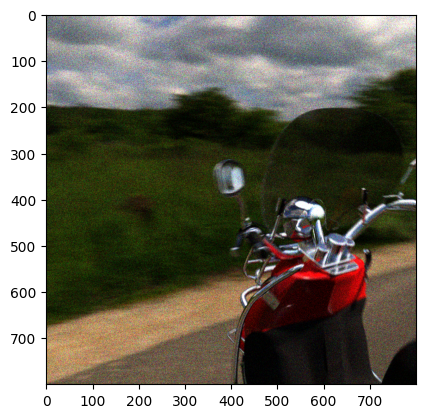

In [20]:
plt.imshow(img)
plt.show()